In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
positions = np.load("positions.npy")

In [3]:
positions.shape

(501, 100, 3)

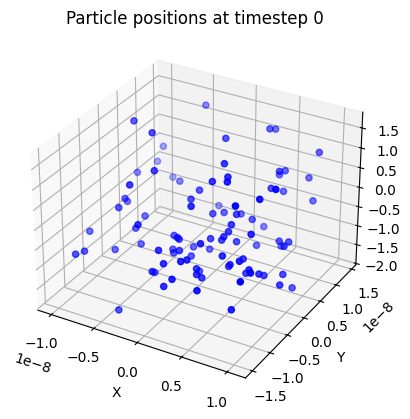

In [13]:
# Choose a timestep, e.g. timestep 250
t = 0
pos_t = positions[t]  # shape: (100, 3)

# Split x, y, z
x, y, z = pos_t[:, 0], pos_t[:, 1], pos_t[:, 2]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', s=20)

ax.set_title(f"Particle positions at timestep {t}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [ ]:
positions[0:100, :, :]

(100, 100, 3)

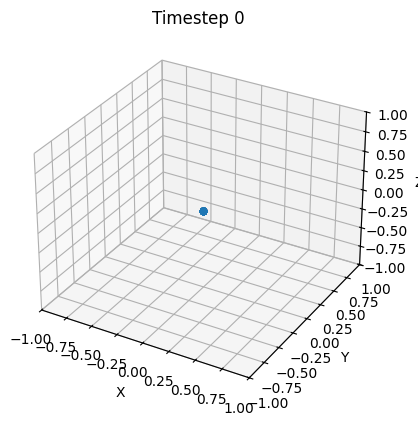

In [12]:
positions = positions[0:100, :, :]


# Basic plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initial scatter plot
scat = ax.scatter([], [], [], s=20)

# Set static plot limits (optional: you can use np.max or np.percentile to compute from data)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Animation update function
def update(frame):
    pos = positions[frame]
    scat._offsets3d = (pos[:, 0], pos[:, 1], pos[:, 2])
    ax.set_title(f"Timestep {frame}")
    return scat,

# Create animation
anim = FuncAnimation(fig, update, frames=range(positions.shape[0]), interval=50)

# Save as animated GIF
anim.save("particle_motion.gif", writer=PillowWriter(fps=5))